# Нейронные сети
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW05] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

In [55]:
import numpy as np
import copy
from sklearn.datasets import make_blobs, make_moons
from typing import List, NoReturn

### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.

`Softmax` - слой, соответствующий функции активации [softmax](https://ru.wikipedia.org/wiki/Softmax)


#### Методы
`forward(X)` - возвращает предсказанные для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

In [436]:
class Module:
    """
    Абстрактный класс. Его менять не нужно.
    """
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, d):
        raise NotImplementedError()
        
    def update(self, alpha):
        pass

In [513]:
class Linear(Module):
    """
    Линейный полносвязный слой.
    """
    def __init__(self, in_features: int, out_features: int):
        """
        Parameters
        ----------
        in_features : int
            Размер входа.
        out_features : int 
            Размер выхода.
    
        Notes
        -----
        W и b инициализируются случайно.
        """
        self.W = np.random.randn(in_features, out_features)
        self.b = np.random.randn(out_features)[np.newaxis, :] 
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = Wx + b.

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
            То есть, либо x вектор с in_features элементов,
            либо матрица размерности (batch_size, in_features).
    
        Return
        ------
        y : np.ndarray
            Выход после слоя.
            Либо вектор с out_features элементами,
            либо матрица размерности (batch_size, out_features)

        """
        if debug_on:
            print("LINEAR_FORWARD. IN: ",x.shape)
            print("LINEAR_FORWARD. OUT: ",(np.matmul(x, self.W) + self.b).shape)
        self.x = x
        
        if self.x.ndim == 1:
            self.x = self.x[np.newaxis, :]
        
        return np.matmul(x, self.W) + self.b
    
    def backward(self, d: np.ndarray) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        
        if d.ndim == 1:
            d = d[np.newaxis,:]
            

        
        if debug_on:
            print("LINEAR_BACKWARD. IN: d=",d.shape)
#             print("LINEAR_BACKWARD. self.x.T=",self.x.T)
#             print("LINEAR_BACKWARD. self.W=",self.W)
#             print('x.T shape', self.x.T.shape)
#             print('d shape:', d.shape)
            print("LINEAR_BACKWARD. OUT:",np.matmul(d, self.W.T).shape)
            
        self.grad_W = np.matmul(self.x.T, d)
        self.grad_b = d
        return np.matmul(d, self.W.T)
        
    def update(self, alpha: float) -> NoReturn:
        """
        Обновляет W и b с заданной скоростью обучения.

        Parameters
        ----------
        alpha : float
            Скорость обучения.
        """
        
        self.W -= alpha * self.grad_W
        self.b -= alpha * self.grad_b.sum(axis=0)[np.newaxis, :]

In [514]:
class ReLU(Module):
    """
    Слой, соответствующий функции активации ReLU.
    """
    def __init__(self):
        pass
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = max(0, x).

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
    
        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        
        y = np.copy(x)
        y[y < 0] = 0
        
        self.y = y
        
        if debug_on == True:
            print('RELU_FORWARD, IN: ', x.shape)
            print('RELU_FORWARD, OUT: ', y.shape)
            
        return y
        
    def backward(self, d) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        
        self.y[self.y > 0] = 1
        
        grad = self.y
        
        if debug_on == True:
            print('RELU_BACKWARD, IN: ', d.shape)
#             print('RELU_BACKWARD, grad=', grad)
            print('RELU_BACKWARD, OUT: ', (d * grad).shape)
        
        return d * grad
        

In [515]:
class Softmax(Module):
    """
    Слой, соответствующий функции активации Softmax.
    """
    def __init__(self):
        pass
        
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = Softmax(x).

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
    
        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        
        self.x = x
        if debug_on:
            print('SOFTMAX_FORWARD, IN: ', x.shape)
            print('SOFTMAX_FORWARD, OUT: ', (np.exp(x)/np.exp(x).sum()).shape )
        return np.exp(x)/np.exp(x).sum(axis=1)[:, np.newaxis]
        
    def backward(self, d) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        exp_x = np.exp(self.x)
        grad = exp_x * exp_x.sum(axis=1)[:, np.newaxis] - exp_x * exp_x
        grad /= exp_x.sum(axis=1)[:, np.newaxis]**2
        
        if debug_on == True:
            print('SOFTMAX_BACKWARD, IN: ', d.shape)
#             print('SOFTMAX_BACKWARD, grad=', grad.shape)
            
            print('SOFTMAX_BACKWARD, OUT: ', (d * grad).shape)
        return d * grad

### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

In [544]:
def get_batches():
    batch_start = 0
    batch_end = batch_size

    while True:
        if batch_start >= 100:
            return
        if batch_end > 100:
            yield batch_start, 100
            return 
        yield batch_start, batch_end
        batch_start += batch_size
        batch_end += batch_size

In [596]:
class MLPClassifier:
    def __init__(self, modules: List[Module], epochs: int = 40, alpha: float = 0.01):
        """
        Parameters
        ----------
        modules : List[Module]
            Cписок, состоящий из ранее реализованных модулей и 
            описывающий слои нейронной сети. 
            В конец необходимо добавить Softmax.
        epochs : int
            Количество эпох обучения
        alpha : float
            Cкорость обучения.
        """
        
        self.modules = modules + [Softmax()]
        self.epochs = epochs
        self.alpha = alpha
            
    def fit(self, X: np.ndarray, y: np.ndarray, batch_size=32) -> NoReturn:
        """
        Обучает нейронную сеть заданное число эпох. 
        В каждой эпохе необходимо использовать cross-entropy loss для обучения, 
        а так же производить обновления не по одному элементу, а используя батчи.

        Parameters
        ----------
        X : np.ndarray
            Данные для обучения.
        y : np.ndarray
            Вектор меток классов для данных.
        batch_size : int
            Размер батча.
        """
        
        X = np.copy(X)
        
        def get_batches():
            batch_start = 0
            batch_end = batch_size
            
            while True:
                if batch_start >= len(X):
                    return
                if batch_end > len(X):
                    yield batch_start, len(X)
                    return 
                yield batch_start, batch_end
                batch_start += batch_size
                batch_end += batch_size
        
        y_vect = np.zeros((len(y), len(np.unique(y))))
        for i in range(len(y)):
            y_vect[i, y[i]] = 1
                          
        for i in range(self.epochs):
#             np.random.shuffle(X)
            for start, end in get_batches():
                result = X[start:end]
                for module in self.modules:
                    result = module.forward(result)
                          
                y_true = np.copy(y_vect[start:end])
                
#                 LOSS
#                 print(-1*np.log(result[:,y_true]))
                if loss:
                    print('LOSS:',-1*(y_true * np.log(result)).mean())
                     
                          
#                 производная кросс-энтропии
                y_true[y_true != 0] /= result[y_true != 0]
                d = y_true * -1             
                          
#                 d = np.zeros(result.shape)
#                 d[0,y_true] = -1/result[0,y_true]
                
                if debug_on:
                    print('-----------BACKWARD-----------BACKWARD-----------BACKWARD-----------')
                
                for module in self.modules[::-1]:
                    d = module.backward(d)
                    module.update(self.alpha)
        
        
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает вероятности классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.
        
        Return
        ------
        np.ndarray
            Предсказанные вероятности классов для всех элементов X.
            Размерность (X.shape[0], n_classes)
        
        """
        all_ = []
        result = X
        for module in self.modules:
            result = module.forward(result)
        
        return result
            
        
    def predict(self, X) -> np.ndarray:
        """
        Предсказывает метки классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.
        
        Return
        ------
        np.ndarray
            Вектор предсказанных классов
        
        """
        p = self.predict_proba(X)
        return np.argmax(p, axis=1)

In [608]:
loss=False

In [580]:
p = MLPClassifier([
    Linear(4, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)
], alpha = 0.000006, epochs = 3000)

X = np.random.randn(50, 4)
y = [(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X]
p.fit(X, y)

LOSS: 13.306191323704688
LOSS: 15.51391296094377
LOSS: 13.243556618408078
LOSS: 15.402366700464146
LOSS: 13.181154308511713
LOSS: 15.291026590530313
LOSS: 13.118804475201994
LOSS: 15.180456440159219
LOSS: 13.056585856112905
LOSS: 15.070032131314877
LOSS: 12.994483722442265
LOSS: 14.959719781936615
LOSS: 12.932485071938011
LOSS: 14.849491271284482
LOSS: 12.870573610138045
LOSS: 14.73932567232378
LOSS: 12.80873658382159
LOSS: 14.629263297200374
LOSS: 12.746964957332043
LOSS: 14.519315812370419
LOSS: 12.685252526277306
LOSS: 14.408874322338656
LOSS: 12.623701986232266
LOSS: 14.296871561821316
LOSS: 12.562206087824022
LOSS: 14.185102897986571
LOSS: 12.500765882239278
LOSS: 14.073655661081734
LOSS: 12.439385162722347
LOSS: 13.962654459927872
LOSS: 12.37807082964081
LOSS: 13.852153448197079
LOSS: 12.316156939453016
LOSS: 13.738947389313463
LOSS: 12.25433271434583
LOSS: 13.626835817197863
LOSS: 12.192613787532384
LOSS: 13.516096440786036
LOSS: 12.131011638452577
LOSS: 13.40693848425031
LOSS: 

LOSS: 4.716437234983177
LOSS: 3.5570842733451946
LOSS: 4.692670111243003
LOSS: 3.534616788509723
LOSS: 4.669150107236884
LOSS: 3.512340478168094
LOSS: 4.6458720394512785
LOSS: 3.4902507459556364
LOSS: 4.62282941619554
LOSS: 3.4683426763538416
LOSS: 4.600014501762136
LOSS: 3.4466110454586043
LOSS: 4.5774184562270275
LOSS: 3.4250503563376378
LOSS: 4.555031526148203
LOSS: 3.4036548891226066
LOSS: 4.5328432625107755
LOSS: 3.382418757715711
LOSS: 4.510842745461138
LOSS: 3.3613359670364926
LOSS: 4.4890187998242235
LOSS: 3.3404004667558294
LOSS: 4.467396055936628
LOSS: 3.31980382065704
LOSS: 4.44643570793291
LOSS: 3.299337407368494
LOSS: 4.4256156235529
LOSS: 3.278995484017224
LOSS: 4.404925629541774
LOSS: 3.258772422836242
LOSS: 4.384355983982328
LOSS: 3.2386627295753687
LOSS: 4.363897425014692
LOSS: 3.2186610585271693
LOSS: 4.343541201255725
LOSS: 3.1987622252386125
LOSS: 4.323279087365139
LOSS: 3.1789612179098556
LOSS: 4.303103388005563
LOSS: 3.159253208411387
LOSS: 4.283006933119952
LOSS:

LOSS: 1.4616690971095043
LOSS: 1.421504326335619
LOSS: 1.455605678496075
LOSS: 1.4086560270403576
LOSS: 1.449542181309254
LOSS: 1.39582547270663
LOSS: 1.443478597890016
LOSS: 1.3830146111978086
LOSS: 1.4374149208630476
LOSS: 1.370225554036797
LOSS: 1.431351143244108
LOSS: 1.357460579824985
LOSS: 1.4252930543038267
LOSS: 1.3447195560903409
LOSS: 1.4191932728179764
LOSS: 1.332007675146242
LOSS: 1.4130934505350892
LOSS: 1.3193277122528198
LOSS: 1.406993605562295
LOSS: 1.3066826030491832
LOSS: 1.4008937396951302
LOSS: 1.2940754050666037
LOSS: 1.394793821418015
LOSS: 1.2815093060871003
LOSS: 1.38869385193959
LOSS: 1.2689875912174546
LOSS: 1.3825938347742384
LOSS: 1.25651361409414
LOSS: 1.3764937761381901
LOSS: 1.2440907628658162
LOSS: 1.3703936853758307
LOSS: 1.231722421321471
LOSS: 1.3642935754099021
LOSS: 1.2194119258375613
LOSS: 1.3581934632073371
LOSS: 1.2071625191351796
LOSS: 1.3520933702502211
LOSS: 1.194977302143118
LOSS: 1.3459933229995509
LOSS: 1.1828591855241437
LOSS: 1.3398933533

LOSS: 0.5153023208321453
LOSS: 0.2442503887814984
LOSS: 0.5125485624101862
LOSS: 0.24229276893376067
LOSS: 0.5098374607014352
LOSS: 0.2403398483466032
LOSS: 0.5071997191656004
LOSS: 0.23842674294902644
LOSS: 0.504570180324474
LOSS: 0.2364817916937795
LOSS: 0.5019906091410286
LOSS: 0.23454002466344134
LOSS: 0.49945628396018005
LOSS: 0.23260100011308948
LOSS: 0.49699263682613903
LOSS: 0.23069894981479153
LOSS: 0.49454766263049055
LOSS: 0.22876432287315643
LOSS: 0.4921511226301226
LOSS: 0.22683127836889846
LOSS: 0.4898013575314052
LOSS: 0.22489948352216824
LOSS: 0.48753071781938295
LOSS: 0.2230020077550753
LOSS: 0.48526275829777227
LOSS: 0.2210719240196883
LOSS: 0.48305299670638085
LOSS: 0.2191422389432226
LOSS: 0.4809071460762648
LOSS: 0.2172449424094344
LOSS: 0.47879199881264195
LOSS: 0.21531547217550306
LOSS: 0.47672054606993364
LOSS: 0.21338575928805942
LOSS: 0.474705303772458
LOSS: 0.21148663234807863
LOSS: 0.47273068977517446
LOSS: 0.20955603994338448
LOSS: 0.4707929699220031
LOSS: 

C:\Users\gaziz\AppData\Local\Temp/ipykernel_14088/2851664155.py:45: RuntimeWarning: overflow encountered in square
  grad /= exp_x.sum(axis=1)[:, np.newaxis]**2
C:\Users\gaziz\AppData\Local\Temp/ipykernel_14088/2851664155.py:44: RuntimeWarning: overflow encountered in multiply
  grad = exp_x * exp_x.sum(axis=1)[:, np.newaxis] - exp_x * exp_x
C:\Users\gaziz\AppData\Local\Temp/ipykernel_14088/2851664155.py:44: RuntimeWarning: invalid value encountered in subtract
  grad = exp_x * exp_x.sum(axis=1)[:, np.newaxis] - exp_x * exp_x


 nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS:

LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan
LOSS: nan


KeyboardInterrupt: 

In [ ]:
lol = 22

In [316]:
p.modules[4].W.max()

nan

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

#### Оценка
Accuracy на первом датасете больше 0.85 - +1 балл

Accuracy на втором датасете больше 0.85 - +1 балл

In [611]:
X, y = make_moons(400, noise=0.075)
X_test, y_test = make_moons(400, noise=0.075)

best_acc = 0
for _ in range(1):
    p = MLPClassifier([
        Linear(2, 10),
        ReLU(),
        Linear(10, 10),
        ReLU(),
        Linear(10, 2)
    ], alpha = 0.000001, epochs = 5000)


    p.fit(X, y, batch_size=400)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.91


In [633]:
loss=False

In [636]:
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
best_acc = 0
for _ in range(1):
    p = MLPClassifier([
        Linear(2, 10),
        ReLU(),
        Linear(10, 10),
        ReLU(),
        Linear(10, 3)
    ], alpha = 0.000001, epochs = 2000)

    p.fit(X, y, batch_size=50)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.905


## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

Files already downloaded and verified
Files already downloaded and verified


### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [130]:
pool = nn.MaxPool2d(kernel_size=2, stride=2)
conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
conv2 = nn.Conv2d(in_channels=6, out_channels=18, kernel_size=3)

In [131]:
x.shape

torch.Size([1024, 3, 32, 32])

In [132]:
conv1(x).shape

torch.Size([1024, 6, 30, 30])

In [133]:
pool(conv1(x)).shape

torch.Size([1024, 6, 15, 15])

In [134]:
conv2(pool(conv1(x))).shape

torch.Size([1024, 18, 13, 13])

In [135]:
(pool(conv2(pool(conv1(x))))).shape

torch.Size([1024, 18, 6, 6])

In [117]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=18, kernel_size=3)
        
        self.lin1 = nn.Linear(18*6*6, 60)
        self.lin2 = nn.Linear(60, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(self.conv1(x))
#         x = self.relu(x)
        x = self.pool(self.conv2(x))
#         x = self.relu(x)
        x = x.flatten(start_dim=1)
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        x = self.relu(x)
        return x
        
def calculate_loss(X: torch.Tensor, y: torch.Tensor, model: Model):
    """
    Cчитает cross-entropy.

    Parameters
    ----------
    X : torch.Tensor
        Данные для обучения.
    y : torch.Tensor
        Метки классов.
    model : Model
        Модель, которую будем обучать.

    """
    
    y_pred = model.forward(X)
    loss = F.cross_entropy(y_pred, y)
    
    return loss

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [118]:
def train(model, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [119]:
model = Model().to(device)
train_l, test_l = train(model)

KeyboardInterrupt: 

Построим график функции потерь

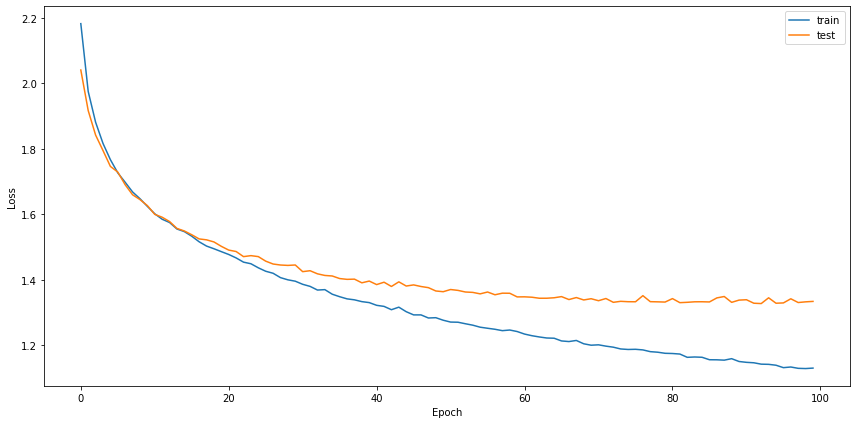

In [100]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [105]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

Overall accuracy 0.549
Precision [0.44100119 0.73178458 0.49017467 0.40071878 0.50842946 0.47179946
 0.7260274  0.63380282        nan 0.64154412]
Recall [0.74  0.693 0.449 0.446 0.573 0.527 0.689 0.675 0.    0.698]
Mean Precision nan
Mean Recall 0.549


C:\Users\gaziz\AppData\Local\Temp/ipykernel_9984/1591066153.py:28: RuntimeWarning: invalid value encountered in true_divide
  print("Precision", true_positive / (true_positive + false_positive))
C:\Users\gaziz\AppData\Local\Temp/ipykernel_9984/1591066153.py:30: RuntimeWarning: invalid value encountered in true_divide
  print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))


In [104]:
false_positive

array([938., 254., 467., 667., 554., 590., 260., 390.,   0., 390.])

In [102]:
true_positive

array([740., 693., 449., 446., 573., 527., 689., 675.,   0., 698.])

In [106]:
false_negative

array([ 260.,  307.,  551.,  554.,  427.,  473.,  311.,  325., 1000.,
        302.])